# Workload Analysis

This notebook identify representative workload classes (e.g., short CPU-bound jobs, GPU-heavy jobs, data-intensive analytics, multi-node MPI jobs, etc.) from Perlmutter job traces.


We'll implement K-means clustering and use the elbow method to find the optimal number of clusters, with progress visualization using tqdm.

**Imports**

In [13]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import eda_utils
import clustering_utils
import visualization_utils

**Load Dataset**

In [2]:
print("Loading dataset...")
X,y = load_iris(return_X_y=True)

df = pl.DataFrame({
    "sepal_length": X[:,0],
    "sepal_width": X[:,1],
    "petal_length": X[:,2],
    "petal_width": X[:,3],
    "species": y
})

Loading dataset...


**Exploratory Data Analysis**

In [3]:
# Perform exploratory data analysis
eda_utils.describe_dataset(df, target_col='species')


Dataset shape: (150, 5)

First 5 rows:


sepal_length,sepal_width,petal_length,petal_width,species
f64,f64,f64,f64,i64
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0



Data Statistics:


statistic,sepal_length,sepal_width,petal_length,petal_width,species
str,f64,f64,f64,f64,f64
"""count""",150.0,150.0,150.0,150.0,150.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",5.843333,3.057333,3.758,1.199333,1.0
"""std""",0.828066,0.435866,1.765298,0.762238,0.819232
"""min""",4.3,2.0,1.0,0.1,0.0
"""25%""",5.1,2.8,1.6,0.3,0.0
"""50%""",5.8,3.0,4.4,1.3,1.0
"""75%""",6.4,3.3,5.1,1.8,2.0
"""max""",7.9,4.4,6.9,2.5,2.0



species Distribution:


species,count
i64,u32
1,50
2,50
0,50


<Figure size 1500x1000 with 0 Axes>

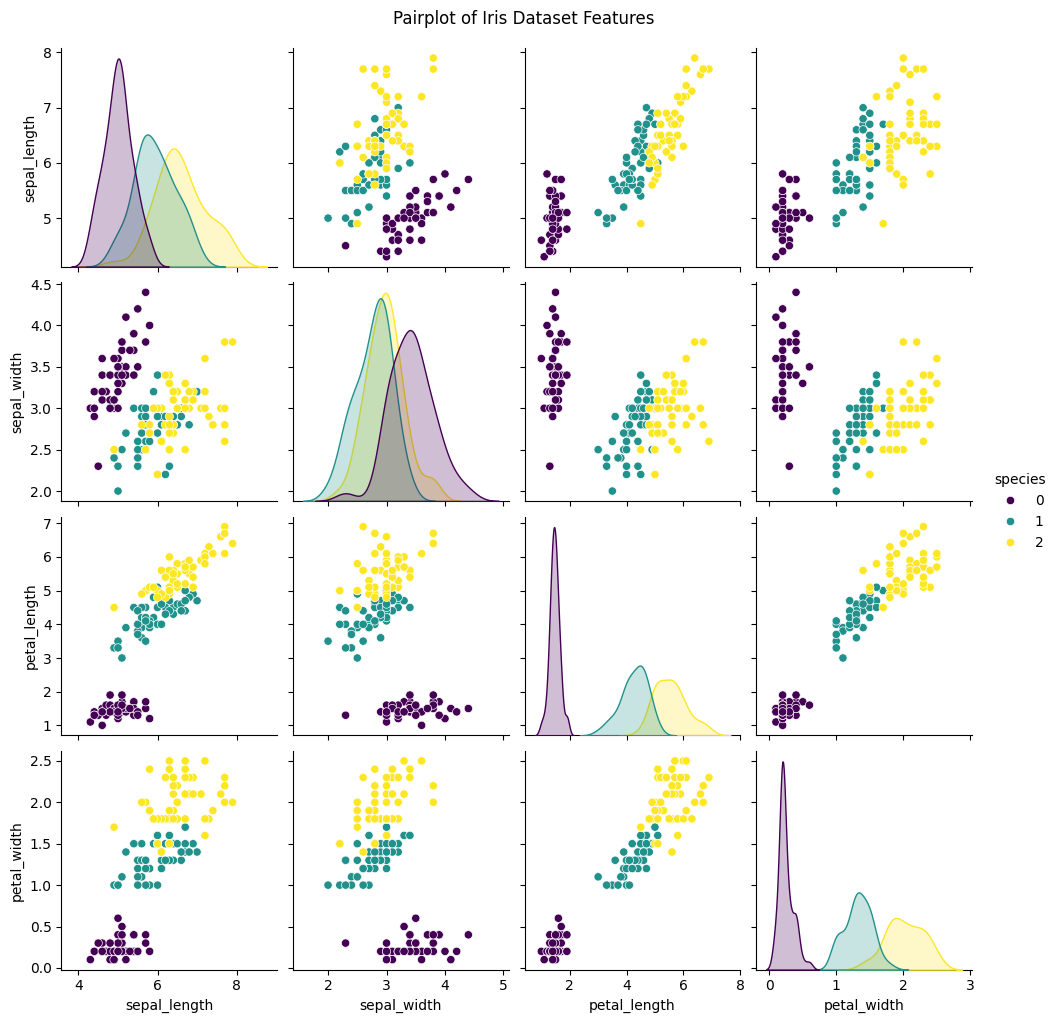

In [15]:
# Create a pairplot to visualize relationships between features
visualization_utils.plot_pairplot(df, hue='species', title='Pairplot of Iris Dataset Features');


In [5]:
# Standardize the features (excluding the target column)
scaled_df, scaler = eda_utils.standardize_features(df, exclude_cols=['species'])
print("Standardized Features:")
display(scaled_df.head())

# Get standardized data for clustering
X = scaled_df.to_numpy()

# Find optimal number of clusters using the elbow method
k_range = range(1, 11)
inertias, times = clustering_utils.find_optimal_k(X, k_range=k_range, verbose=True)


Standardized Features:


sepal_length_scaled,sepal_width_scaled,petal_length_scaled,petal_width_scaled
f64,f64,f64,f64
-0.900681,1.019004,-1.340227,-1.315444
-1.143017,-0.131979,-1.340227,-1.315444
-1.385353,0.328414,-1.397064,-1.315444
-1.506521,0.098217,-1.283389,-1.315444
-1.021849,1.249201,-1.340227,-1.315444


Finding optimal k:   0%|          | 0/10 [00:00<?, ?it/s]

K=1: Inertia=600.00, Time=0.0761s
K=2: Inertia=222.36, Time=0.0110s
K=3: Inertia=139.82, Time=0.0141s
K=4: Inertia=114.09, Time=0.0221s
K=5: Inertia=90.93, Time=0.0116s
K=6: Inertia=81.54, Time=0.0127s
K=7: Inertia=72.63, Time=0.0137s
K=8: Inertia=62.54, Time=0.0148s
K=9: Inertia=55.12, Time=0.0178s
K=10: Inertia=47.39, Time=0.0182s


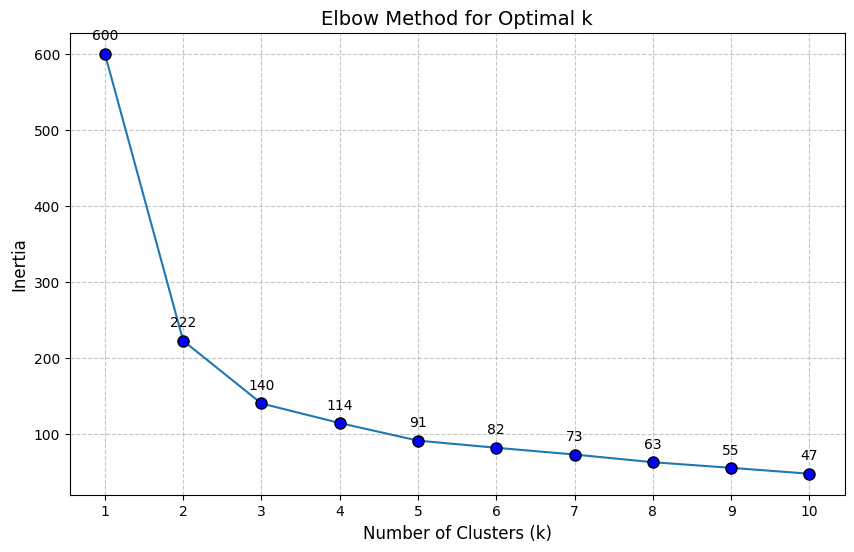

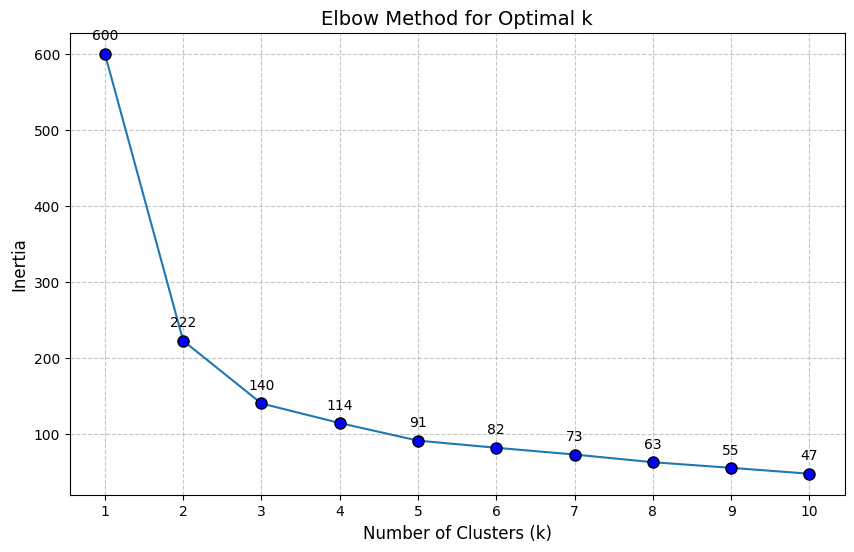

In [6]:
# Plot the elbow curve
visualization_utils.plot_elbow_method(k_range, inertias, annotate=True)


In [7]:
# Apply KMeans clustering with the optimal number of clusters
optimal_k = 3  # Based on the elbow method
labels, centers, n_clusters = clustering_utils.apply_clustering(
    X, algorithm="kmeans", params={"n_clusters": optimal_k}
)

# Add cluster labels to the original dataframe
result_df = df.with_columns(pl.Series(name="cluster", values=labels))

# Display results
print("Clustering Results:")
display(result_df.head())

# Compare clusters with original species
print("\nCluster vs. Species Distribution:")
display(result_df.group_by(['species', 'cluster']).agg(pl.len().alias('count')))


Clustering Results:


sepal_length,sepal_width,petal_length,petal_width,species,cluster
f64,f64,f64,f64,i64,i32
5.1,3.5,1.4,0.2,0,1
4.9,3.0,1.4,0.2,0,1
4.7,3.2,1.3,0.2,0,1
4.6,3.1,1.5,0.2,0,1
5.0,3.6,1.4,0.2,0,1



Cluster vs. Species Distribution:


species,cluster,count
i64,i32,u32
1,0,39
2,2,36
0,1,50
1,2,11
2,0,14


In [8]:

# Reduce dimensions for visualization
X_pca = visualization_utils.reduce_dimensions(X, method="pca", n_components=2)
centers_pca = visualization_utils.reduce_dimensions(centers, method="pca", n_components=2)


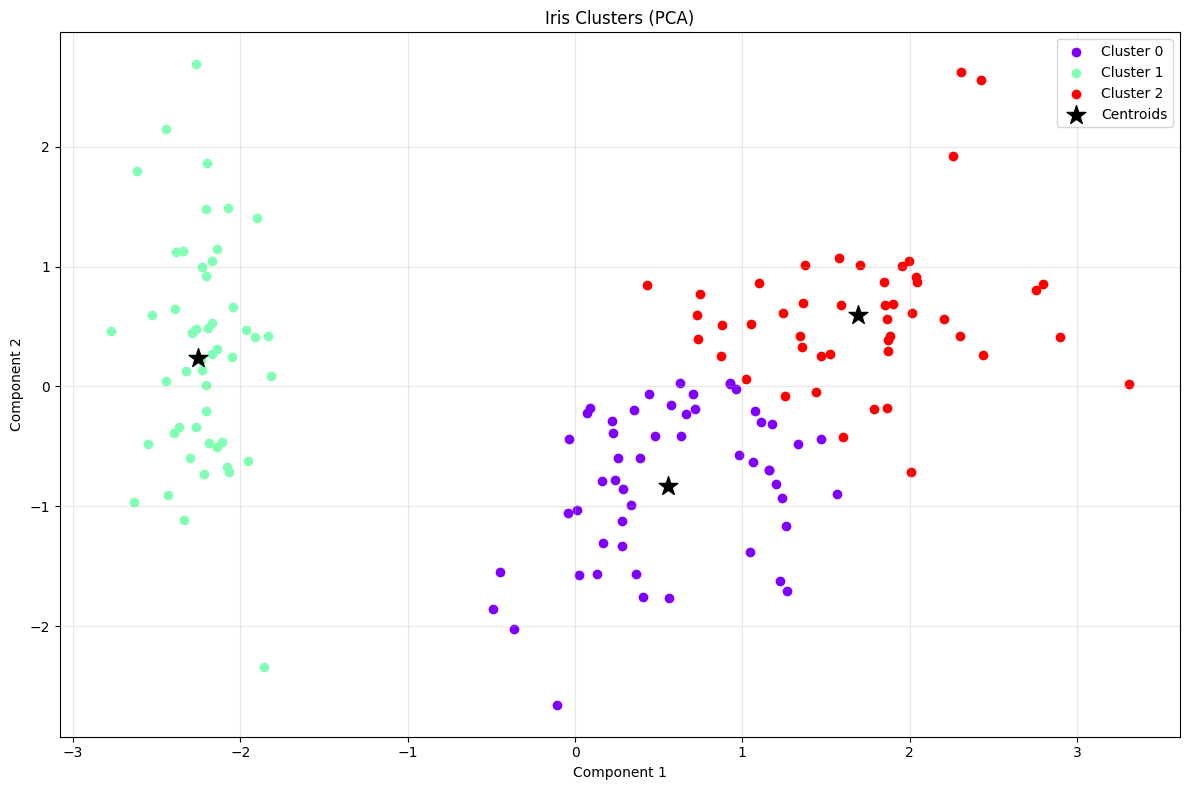

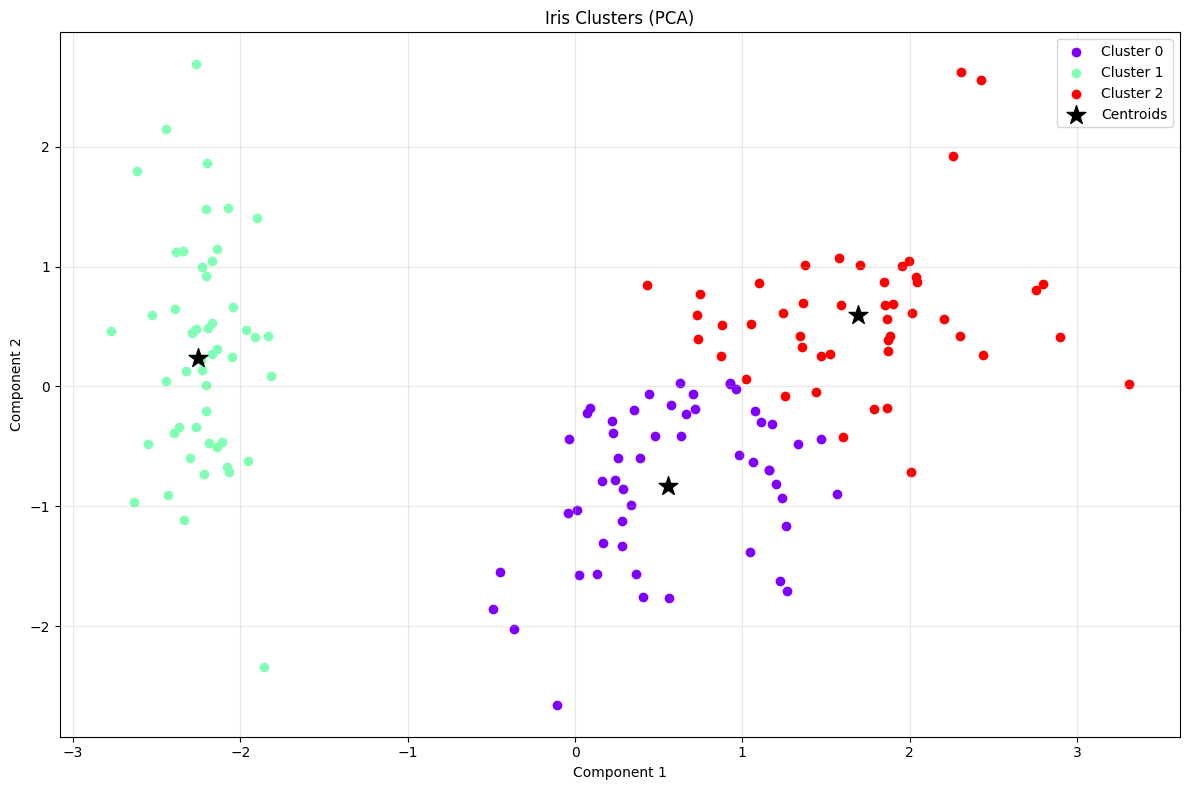

In [9]:

# Visualize the clusters using matplotlib
visualization_utils.plot_clusters_mpl(
    X_pca, labels, centers_pca, 
    title='Iris Clusters (PCA)'
)


In [10]:
# Visualize the clusters using plotly for interactivity
fig = visualization_utils.plot_clusters_plotly(
    X_pca, labels, centers_pca,
    point_labels=result_df['species'].to_list(),
    title='Interactive Iris Clusters (PCA)'
)
fig.show()


In [11]:

# For 3D visualization
X_pca_3d = visualization_utils.reduce_dimensions(X, method="pca", n_components=3)
centers_pca_3d = visualization_utils.reduce_dimensions(centers, method="pca", n_components=3)

fig_3d = visualization_utils.plot_clusters_plotly(
    X_pca_3d, labels, centers_pca_3d,
    point_labels=result_df['species'].to_list(),
    title='Interactive Iris Clusters (PCA 3D)'
)
fig_3d.show()

**Data Visualization**

**Data Preprocessing**

**Elbow Method**

**Clustering with Optimal K**

**Visualization**